### Code Beigns

The csv file for data and the python notebook are assumed to be in the same folder.


Import the packages and libraries

#### Import Libraries

In [1]:
#Import packages

# Basic libraries
import numpy as np
import pandas as pd
import random as rd
import datetime
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns


#Time Series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

#### Data Import

In [2]:
#Import Dataset
df = pd.read_csv("sales_train_v2.csv")

In [3]:
#shape of the dataframe before cleaning
df.shape

(2935849, 6)

In [4]:
#Get the top rows of the dataframe
df.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [5]:
#Get the unique values for each column
print('Unique values for')
print('Date Block Number: ',df['date_block_num'].unique().shape)
print('Shops: ', df['shop_id'].unique().shape)
print('Items: ', df['item_id'].unique().shape)
print('Prices: ', df['item_price'].unique().shape)
print('Item Count per Day: ', df['item_cnt_day'].unique().shape)

Unique values for
Date Block Number:  (34,)
Shops:  (60,)
Items:  (21807,)
Prices:  (19993,)
Item Count per Day:  (198,)


#### Data Cleaning

Check if the features have correct datatype.

In [6]:
#check if datatype are correct
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [7]:
#Format the date column to correct date type
df.date=df.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


Next check for the null values in the data

In [9]:
df.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

Since there are no null values in the data, it is not required to handle those. However there are few negative values in item_cnt_day column.

In [10]:
#negative values in item_cnt_day column
print(df[df['item_cnt_day'] < 0].shape)

(7356, 6)


There are 7356 negative item count and the items can't be negative. But the items that have been returned to the store could be marked as negative. Hence, to assume that item_cnt_day marks the value as negative if the item has been returned to store.

#### Data Preparation

In [11]:
#getting the monthly sales data
monthly_sales=df.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [12]:
monthly_sales.head(10)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0

In [13]:
monthly_sales.tail(10)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
33             59      21427   2015-10-04 2015-10-04      169.0          1.0
                       21449   2015-10-30 2015-10-31      449.0          2.0
                       21672   2015-10-14 2015-10-14      249.0          1.0
                       21811   2015-10-27 2015-10-27      199.0          1.0
                       21812   2015-10-17 2015-10-17       99.0          1.0
                       22087   2015-10-05 2015-10-23      119.0          6.0
                       22088   2015-10-03 2015-10-27      119.0          2.0
                       22091   2015-10-03 2015-10-03      179.0          1.0
                       22100   2015-10-18 2015-10-18      629.0          1.0
                       22102   2015-10-16 2015-10-16     1250.0          1.0

In [14]:
#Divide the train data into X and Y to implement KNN to obtain the date_block_num
salesTrainX = df.iloc[:, 2:4]
salesTrainY = df.iloc[:, 1:2]

In [15]:
salesTrainX.head(5)

,shop_id,item_id
0,59,22154
1,25,2552
2,25,2552
3,25,2554
4,25,2555


In [16]:
xTrain, xTest, yTrain, yTest = train_test_split(df, df.item_cnt_day, test_size=0.20)

In [17]:
xTrain.drop(['date'], axis=1, inplace=True)
xTrain.head(5)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,date_block_num,shop_id,item_id,item_price,item_cnt_day
2373962,24,30,7741,299.0,1.0
537019,5,31,3631,1999.0,1.0
2118655,22,29,6926,419.0,1.0
2684794,29,25,3341,1299.0,1.0
2231724,23,31,8471,349.0,1.0


In [18]:
ytrain = yTrain.iloc[2:]

In [19]:
xTest.drop(['date'], axis=1, inplace=True)

#### EDA

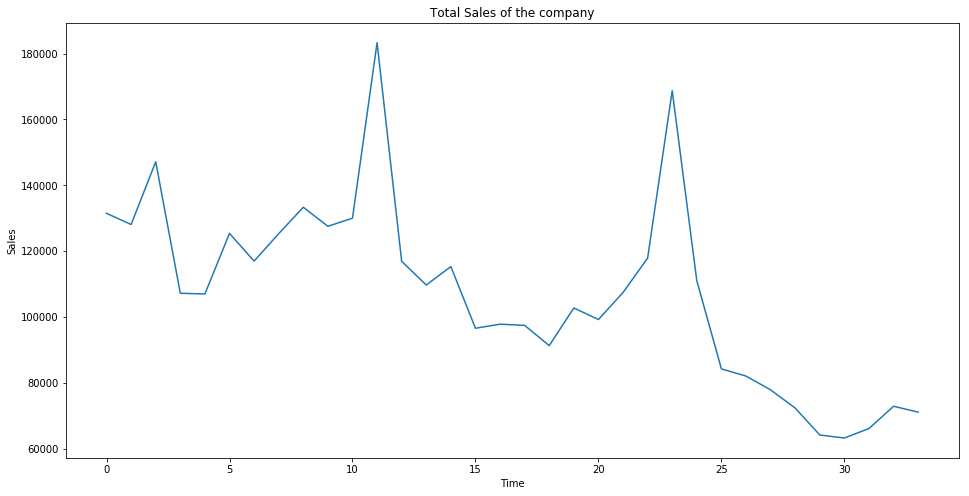

In [20]:
#date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
a=df.groupby(["date_block_num"])["item_cnt_day"].sum()
a.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(a);

In [29]:
df[['item_cnt_day', 'item_price', 'item_id']].sort_values('item_cnt_day', ascending=False).head(20)

,item_cnt_day,item_price,item_id
2909818,2169.0,0.908714,11373
2326930,1000.0,4.000000,20949
2864235,669.0,1692.526158,9248
2851091,637.0,1702.825746,9249
2608040,624.0,1904.548077,3731
2626181,539.0,155.192950,11373
2851073,533.0,1500.000000,9249
2048518,512.0,1500.000000,9242
2067669,508.0,899.000000,19437
2864260,504.0,1500.000000,9248


Text(0, 0.5, 'Count')

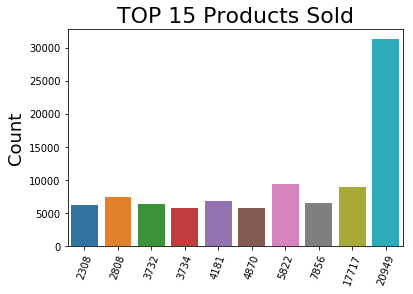

In [34]:
top10 = df.item_id.value_counts()[:10]

itemp = sns.countplot(x='item_id', 
                   data=df[df.item_id.isin(top10.index)])
itemp.set_xticklabels(itemp.get_xticklabels(),rotation=70)
itemp.set_title("TOP 15 Products Sold", fontsize=22)
itemp.set_xlabel("")
itemp.set_ylabel("Count", fontsize=18)

In [35]:
df['item_price'].describe()

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

## Classification Models

### KNN

In [36]:
classifier = KNeighborsClassifier(n_neighbors= 150)
classifier.fit(xTrain, yTrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=150, p=2,
           weights='uniform')

In [37]:
yPred = classifier.predict(xTest)
print(accuracy_score(yTest, yPred))

0.898680109678628


### Naive Bayes

In [38]:
modelNB = GaussianNB()
modelNB.fit(xTrain, yTrain)

GaussianNB(priors=None, var_smoothing=1e-09)

In [39]:
yPredNB = modelNB.predict(xTest)
print('Accuracy for Naive Bayes:', accuracy_score(yTest, yPredNB))

Accuracy for Naive Bayes: 0.9973942810429688


### Decision Tree

In [40]:
dt = tree.DecisionTreeClassifier()
dt.fit(xTrain, yTrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [41]:
yPredDT = dt.predict(xTest)
print('Accuracy for Decision Tree:', accuracy_score(yTest, yPredDT))

Accuracy for Decision Tree: 0.9999472043871451


Here, we see that the accuracy scores for different models are nearly 99% which shows that models are overfit. So, we decided to implement timeseries models.

## Timeseries Models

### ARIMA

Autoregrassive integrated moving average, this is one of the famous modelwhich helped in solving time series problems for a long time. This method helps us in solving the problems with trend with ease, we do not have to linearize the trend before implementing this model as this has the capability to work even with the trends.

How it works.   
This model takes the lags of the data and the error bits, and differntiates the trend to make it stable based on all these three components, it evaluates the data and it works in a linear fashion. This method uses the data from past events and assigns them weight according to thier age, the error is also calcualted in the sismilar manner for the corresponding events and that is used to predict the future events. The problem with this model is it doesnt take seasonality into consideration that is one of the biggest disadvantge.

In [42]:
model = ARIMA(a.values, order=(1,2,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   32
Model:                 ARIMA(1, 2, 3)   Log Likelihood                -365.436
Method:                       css-mle   S.D. of innovations          19400.588
Date:                Fri, 13 Dec 2019   AIC                            742.872
Time:                        16:48:34   BIC                            751.666
Sample:                             2   HQIC                           745.787
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -139.5661    102.924     -1.356      0.186    -341.294      62.161
ar.L1.D2.y     0.4173      0.481      0.868      0.393      -0.525       1.360
ma.L1.D2.y    -1.9726      0.517     -3.813      0.0

In [43]:
import itertools
p = q = d = range(0, 4)
pdq = itertools.product(p, d, q)
for param in pdq:
    try:
        mod = ARIMA(a.values,order=param)
        results = mod.fit()
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
    except:
        continue

ARIMA(0, 0, 0) - AIC:796.8886420086167
ARIMA(0, 0, 1) - AIC:786.0648408996739
ARIMA(0, 0, 2) - AIC:785.8980553701198
ARIMA(0, 0, 3) - AIC:784.5848850501376
ARIMA(0, 1, 0) - AIC:760.2474979126929
ARIMA(0, 1, 1) - AIC:757.5076130982794
ARIMA(0, 1, 2) - AIC:755.6788816384438


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(0, 1, 3) - AIC:757.5245682450777
ARIMA(0, 2, 0) - AIC:768.6292281600458
ARIMA(0, 2, 1) - AIC:743.7861212478325
ARIMA(1, 0, 0) - AIC:779.8683078684189
ARIMA(1, 0, 1) - AIC:781.0861227998067


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(1, 0, 2) - AIC:911.6674062723994
ARIMA(1, 0, 3) - AIC:784.0145062716647
ARIMA(1, 1, 0) - AIC:759.4445712379389
ARIMA(1, 1, 1) - AIC:755.1470983008088
ARIMA(1, 2, 0) - AIC:759.5640370983934
ARIMA(1, 2, 1) - AIC:743.5124937061591


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(1, 2, 2) - AIC:741.4034082560436
ARIMA(1, 2, 3) - AIC:742.8718364491317
ARIMA(2, 0, 0) - AIC:781.3018245268133


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1) - AIC:798.5884543654345
ARIMA(2, 0, 2) - AIC:784.7026618693317
ARIMA(2, 0, 3) - AIC:nan


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:674: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda3/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/anaconda3/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(2, 1, 0) - AIC:758.8145678270005
ARIMA(2, 1, 1) - AIC:760.7936141514492


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(2, 1, 2) - AIC:nan
ARIMA(2, 2, 0) - AIC:750.8804431115099
ARIMA(2, 2, 1) - AIC:743.4037087546129


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: divide by zero encounter

ARIMA(2, 2, 2) - AIC:743.3993939644681
ARIMA(2, 2, 3) - AIC:nan
ARIMA(3, 0, 0) - AIC:782.5678962046712
ARIMA(3, 0, 1) - AIC:784.2937923823856


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(3, 0, 2) - AIC:nan


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(3, 0, 3) - AIC:784.3094552035822
ARIMA(3, 1, 0) - AIC:760.8034424688577
ARIMA(3, 1, 1) - AIC:762.7867234656869


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(3, 1, 3) - AIC:nan
ARIMA(3, 2, 0) - AIC:750.3954073176376


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(3, 2, 1) - AIC:nan
ARIMA(3, 2, 2) - AIC:nan


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


## Tuning the ARIMA model


#### AIC of 1,2,2 is the least, so lets select those and compute 

In [44]:
model = ARIMA(a.values, order=(1,2,2))
result = model.fit()
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   32
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -365.702
Method:                       css-mle   S.D. of innovations          19051.886
Date:                Fri, 13 Dec 2019   AIC                            741.403
Time:                        16:49:00   BIC                            748.732
Sample:                             2   HQIC                           743.833
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -136.1391    116.123     -1.172      0.251    -363.736      91.458
ar.L1.D2.y     0.4013      0.197      2.039      0.051       0.016       0.787
ma.L1.D2.y    -1.9993      0.168    -11.876      0.0

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [45]:
pred = result.predict(start = 24, end=40)
prediction = pd.Series(pred, index=range(24,41,1))

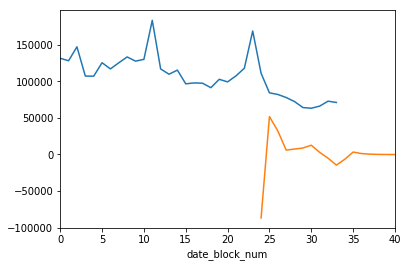

In [46]:
a.plot()
prediction.plot()

## SARIMA

This is termed as Seasonal Autoregrassive Integral Moving Average, this model is an extension or upgraded version of ARIMA model. This algorithm takes the seasonality component of a timeseries into consideration and predicts the future events, this works in a similar way to ARIMA model and the only addition is it takes seasonility into consideration due to which this is better than ARIMA if we have seasonility in our data.

In [47]:
#in this we were getting the result well when we chose this order and seasonality so we chose these values
mod = sm.tsa.statespace.SARIMAX(a.values,
                                            order=(2,2,0),
                                            seasonal_order=(1,1,0,12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   34
Model:             SARIMAX(2, 2, 0)x(1, 1, 0, 12)   Log Likelihood                 -61.954
Date:                            Fri, 13 Dec 2019   AIC                            131.909
Time:                                    16:49:11   BIC                            131.076
Sample:                                         0   HQIC                           128.574
                                             - 34                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5289      0.807     -1.894      0.058      -3.111       0.053
ar.L2         -0.6696      1.321     -0.507      0.612      -3.259       1.920
ar.S.L12       0.5188      0.635      0.817      0.414      -0.726       1.764
sigma2      1.049e+08   2.77e-09   3.79e+16      0.000    1.05e+08    1.05e+08
===================================================================================
Ljung-Box (Q):                       18.54   Jarque-Bera (JB):                 0.85
Prob(Q):                              0.00   Prob(JB):                         0.65
Heteroskedasticity (H):               0.66   Skew:                             0.04
Prob(H) (two-sided):                  0.80   Kurtosis:                         1.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.11e+34. Standard errors may be unstable.
"""

#### Lower the AIC better the model, in this we can clearly see that SARIMA has lower AIC values then ARIMA model

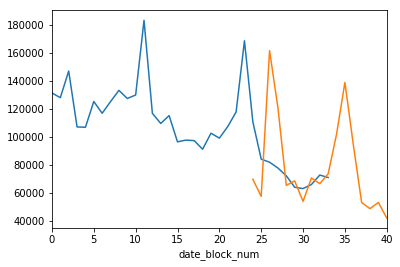

In [48]:
pred = result.predict(start = 24, end=40)
prediction = pd.Series(pred, index=range(24,41,1))
a.plot()
prediction.plot()

Here we can see that the graph of this is better compared to the ARIMA model and most of the values are matching the old trend.

## LSTM

Long short term memory in short known as LSTM is one of the famous algorithm used in neural networks, nowadays this algorithm is gaining lot of transaction and is most widely used in businesses to forecast the trends and quantities, it is mostly used to forecast sales, costs, lifetime of a product etc. it has many advantages over the general time series models such as ARIMA and SARIMA, the biggest advantage is that this model learns from the data without linearly going through the previous data, because of which it needs a lot of data and time to learn from the data, once it does it, it aces the race and predicts better than any other existing models. But the drawback this model has is it needs lot of data and time to train the model.  

How it works?  
It takes three inputs which has the present data the previous and the future data. it stores the historical data and joins with the present data to compute the output. it uses sigmoid and Tanh functions through its way to get rid of error bits and learns about the data by comparing the present state with future and past states. The output of this model can also be modified by the activation function we are using in the final stage.


In [49]:

df.drop(['date'], axis=1, inplace=True)
# here we are keeping all the column except our target
X_train = np.expand_dims(df.values[:,:-1],axis = 2)
# here we are taking only our target column
y_train = df.values[:,-1:]
# for test we keep all the columns execpt the first one
X_test = np.expand_dims(df.values[:,1:],axis = 2)
print(X_train.shape,y_train.shape,X_test.shape)

(2935849, 4, 1) (2935849, 1) (2935849, 4, 1)


In [50]:
#here we are splitting the data again as we need more data points to compute this model
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [51]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
ls_model = Sequential()
ls_model.add(LSTM(units = 64,input_shape = (4,1)))
ls_model.add(Dropout(0.4))
ls_model.add(Dense(1))

ls_model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
ls_model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [52]:
#here we are choosing less epochs as we need more time and computation to find the best fit
ls_model.fit(xTrain, yTrain,batch_size = 4096,epochs = 5)

Epoch 1/5
2348679/2348679 [==============================] - 77s 33us/step - loss: 7.3405 - mean_squared_error: 7.3405
Epoch 2/5
2348679/2348679 [==============================] - 82s 35us/step - loss: 7.1839 - mean_squared_error: 7.1839
Epoch 3/5
2348679/2348679 [==============================] - 76s 32us/step - loss: 7.1689 - mean_squared_error: 7.1689
Epoch 4/5
2348679/2348679 [==============================] - 85s 36us/step - loss: 7.1498 - mean_squared_error: 7.1498
Epoch 5/5
2348679/2348679 [==============================] - 75s 32us/step - loss: 7.1385 - mean_squared_error: 7.1385


This model improves as we train the model on more number of epochs and find where the error is least, and should use those number of epochs in our model, you can see that the error is decreasing as we run more epochs.

In [ ]:
y_pred = ls_model.predict(xTest)

## Refernces

https://www.researchgate.net/post/What_is_the_advantage_of_using_RNN_and_LSTM_over_traditional_methods_for_time_series_of_streaming_data